In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 8
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/diego/local_repos/AGEC652_2024/slides/lecture_8_2"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| include: false
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("Optim")
# Pkg.add("GLM")
# Pkg.add("LinearAlgebra")
# Pkg.add("Plots")
# Pkg.add("LaTeXStrings")
# Pkg.add("DataFrames")
# Pkg.add("CSV")

  Activating project at `~/local_repos/AGEC652_2024/slides/lecture_8_2`


In [3]:
using JuMP, Ipopt
function solve_c_l(w, e, gamma, tau)
    model = Model(Ipopt.Optimizer)
    set_silent(model) # Mute output
    # Declare variables
    @variable(model, c >= 0)
    @variable(model, 0 <= l <= 1)
    # Declare objective
    @objective(model, Max, c^gamma * l^(1-gamma))
    # Declare budget constraint
    @constraint(model, c <= (1-tau)*w*(1-l) + e)
    optimize!(model)
    # Warn if error
    if (termination_status(model) != LOCALLY_SOLVED)
        println("Error: row $i, draw $j $(termination_status(model))")
    end
    c = value(c)
    l = value(l)
    return (c, l)
end;
# Testing this function
solve_c_l(80.0, 2.0, 0.5, 0.1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



(37.00000037123763, 0.5138888934197704)

In [4]:
using Random, Distributions
function solve_Ec_El(w, gamma, tau, R)
    model = Model(Ipopt.Optimizer)
    set_silent(model) # Mute output
    # Declare variables
    @variable(model, c >= 0)
    @variable(model, 0 <= l <= 1)
    # Declare objective
    @objective(model, Max, c^gamma * l^(1-gamma))
    # Declare epsilon as model parameters
    @variable(model, e in Parameter(0.0))
    # Declare budget constraint
    @constraint(model, c <= (1-tau)*w*(1-l) + e)
    # Draw R epsilons
    es = rand(Normal(0.0, 1.0), R)
    # Vectors to store for individual i
    cs_i = zeros(R); ls_i = zeros(R)
    # Loop to simulate
    for i in 1:R
        set_parameter_value(e, es[i]) # Set a drawn value for epsilon
        optimize!(model)
        # Warn if error
        if (termination_status(model) != LOCALLY_SOLVED)
            println("Error in draw $i: $(termination_status(model))")
        end
        cs_i[i] = value(c)
        ls_i[i] = value(l)
    end
    # Take average of simulated values
    Ec = mean(cs_i); El = mean(ls_i)
    return (Ec, El)
end

solve_Ec_El (generic function with 1 method)

In [5]:
solve_Ec_El(80.0, 0.5, 0.1, 50)

(36.02247182786832, 0.5003121081281051)

In [6]:
solve_Ec_El(80.0, 0.5, 0.1, 50)

(36.00056295471791, 0.5000078182239123)

In [7]:
using DataFrames, CSV
df = CSV.read("labor_supply.csv", DataFrame)
df[1:5,:]

Row,ID,wage_rate,consump,labor_hours
,Int64,Float64,Float64,Int64
1,1,20.47,31750.4,1838
2,2,14.94,23850.8,1786
3,3,18.21,29353.2,1768
4,4,16.87,27026.8,1779
5,5,24.1,37958.9,1810


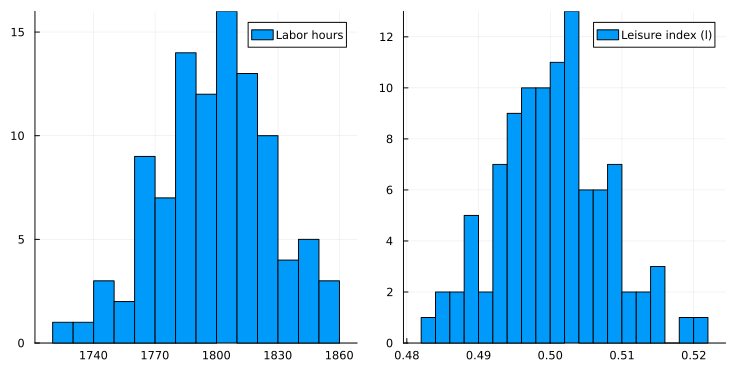

In [8]:
using Plots
df.l = 1 .- (df.labor_hours ./ 3600)
plot(histogram(df.labor_hours, label="Labor hours", bins = 20),
     histogram(df.l, label="Leisure index (l)", bins = 20))

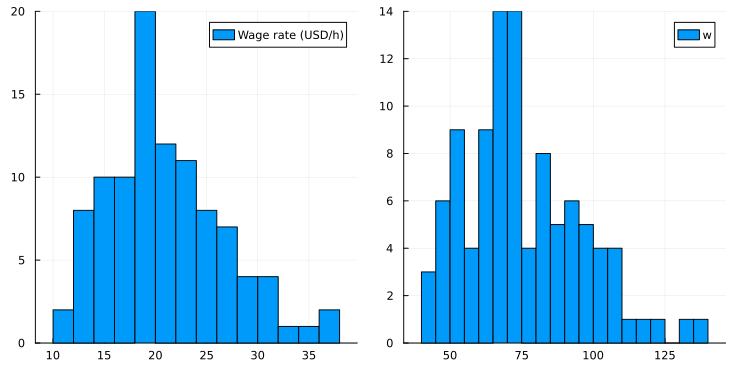

In [9]:
df.w = df.wage_rate .* 3.6
plot(histogram(df.wage_rate, label="Wage rate (USD/h)", bins = 20),
     histogram(df.w, label="w", bins = 20))

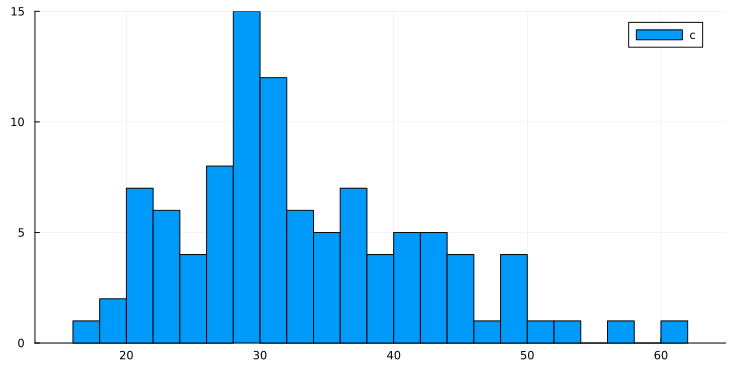

In [10]:
df.c = df.consump ./ 1000
histogram(df.c, label="c", bins = 20)

In [11]:
N = nrow(df)
function solve_all_Ec_El(gamma, tau; R = 20)
    # Vectors to store simulated moments    
    cs = zeros(N)
    ls = zeros(N)
    # Loop over individuals
    for i in 1:N
        cs[i], ls[i] = solve_Ec_El(df.w[i], gamma, tau, R)
    end
    return (cs, ls)
end;
@time solve_all_Ec_El(0.4, 0.1);

  5.784838 seconds (1.63 M allocations: 48.061 MiB, 0.32% gc time, 2.95% compilation time: 98% of which was recompilation)


In [12]:
Threads.nthreads()

1

In [13]:
function parallel_solve_all_Ec_El(gamma, tau; R = 20)
    # Vectors to store simulated moments    
    cs = zeros(N)
    ls = zeros(N)
    # Loop over individuals
    Threads.@threads for i in 1:N
        cs[i], ls[i] = solve_Ec_El(df.w[i], gamma, tau, R)
    end
    return (cs, ls)
end
@time parallel_solve_all_Ec_El(0.4, 0.1);

  5.631107 seconds (1.52 M allocations: 40.392 MiB, 0.28% gc time, 0.93% compilation time)


In [14]:
# Setting them close to the true value
z_0 = [0.01, log(0.14)];
theta_0 = exp.(z_0) ./ (1.0 .+ exp.(z_0)) 

2-element Vector{Float64}:
 0.5024999791668749
 0.12280701754385964

In [15]:
function Q(z)
    # Undo the transformation to get theta back
    theta = exp.(z) ./ (1.0 .+ exp.(z))
    # Unpack theta
    gamma, tau = theta
    # Calculate predicted cs and ls
    cs, ls = parallel_solve_all_Ec_El(gamma, tau)
    # First moment condition: E[c_hat - c]
    M1 = mean(cs .- df.c)
    # Second moment condition: E[l_hat - l]
    M2 = mean(ls .- df.l)
    # Calculate Q and return
    return M1^2 + M2^2
end

Q (generic function with 1 method)

In [16]:
# z_hat = res.minimizer
z_hat = [-0.0004171676757946849, -1.9668945485159541]
# Undo the transformation to get theta back
gamma_hat, tau_hat = exp.(z_hat) ./ (1.0 .+ exp.(z_hat))

2-element Vector{Float64}:
 0.4998957080825638
 0.12272283422850011

In [17]:
function dc_dtau(gamma,tau,h)
    # Calculate c with tau + h
    cs_p, ls_p = parallel_solve_all_Ec_El(gamma, tau + h)
    # Calculate c with tau - h
    cs_m, ls_m = parallel_solve_all_Ec_El(gamma, tau - h)
    # Take differences and average out
    (mean(cs_p - cs_m)) ./ (2*h)
end;

In [18]:
dc_dtau(gamma_hat, tau_hat, 0.01)

-37.46167959979286

In [19]:
-0.5 * mean(df.w)

-37.6542